## Initialization

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [6]:
filepath = '/datasets/faces/final_files/'
df = pd.read_csv('/datasets/faces/labels.csv', sep=',')
df.info()
display(df.describe())
display(df.head())
print(f'Duplicates in data: {df.duplicated().sum()} ({(df.duplicated().sum() / df.shape[0]):.2%})')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000
mean,31.201
std,17.145
min,1.000
25%,20.000
50%,29.000
75%,41.000
max,100.000


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Duplicates in data: 0 (0.00%)


## EDA

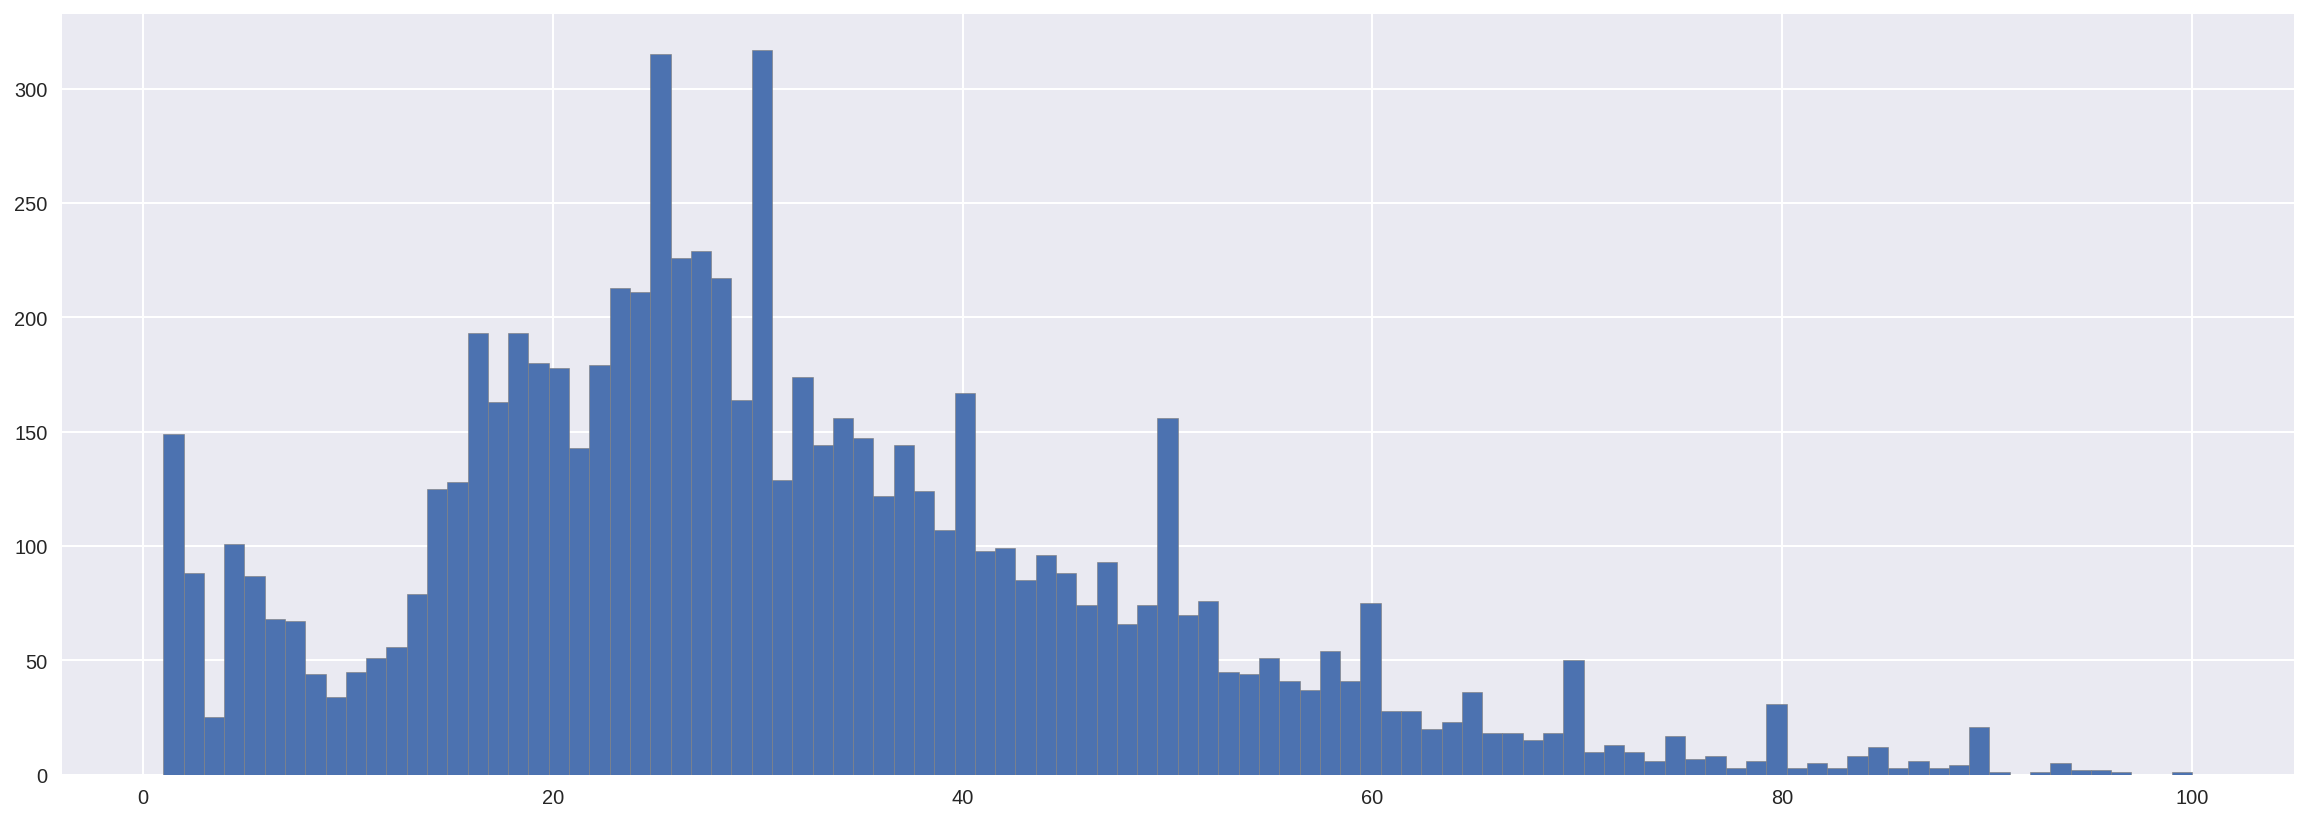

In [7]:
df['real_age'].hist(figsize=(20,7), bins=100, edgecolor='gray');

Age: 25


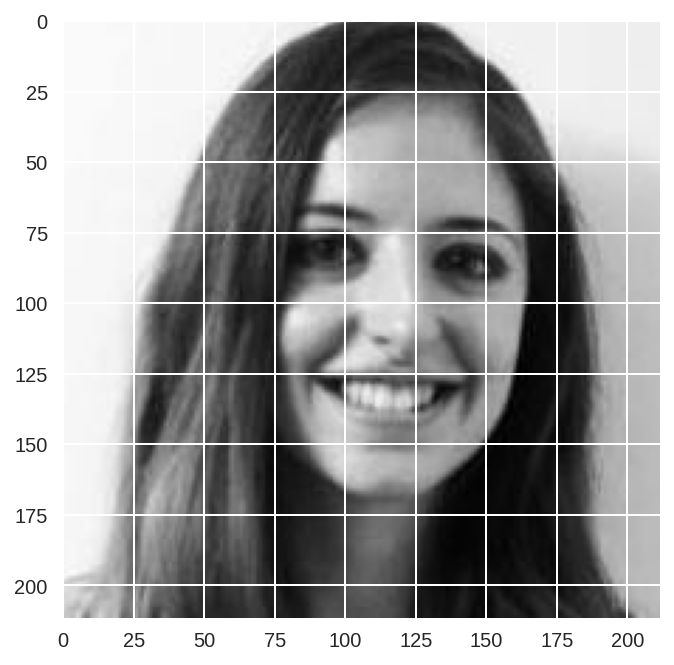


Age: 21


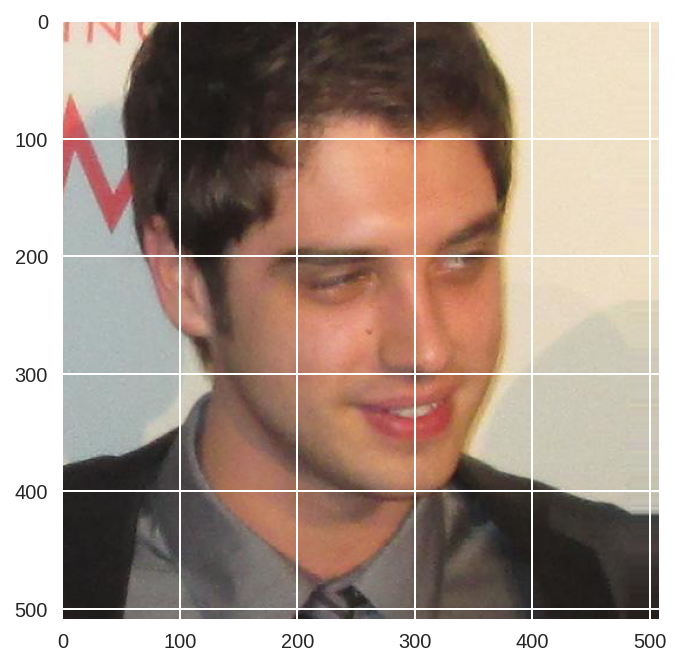


Age: 26


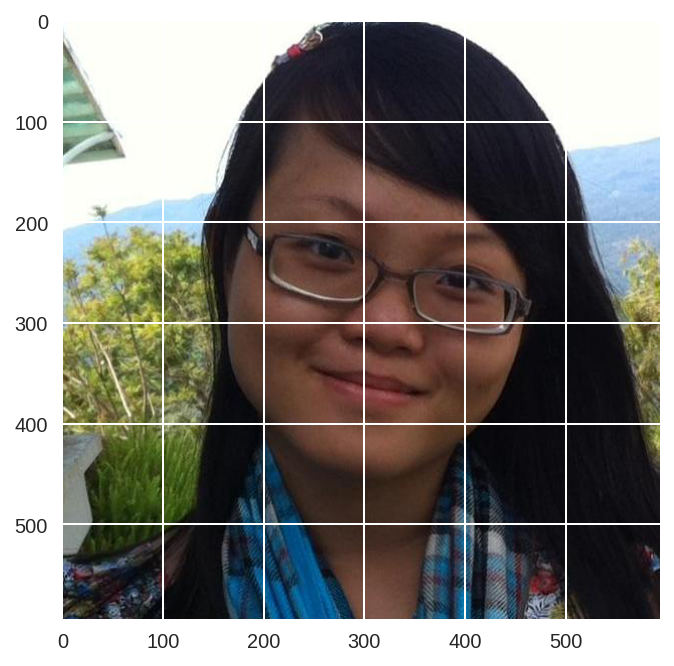


Age: 49


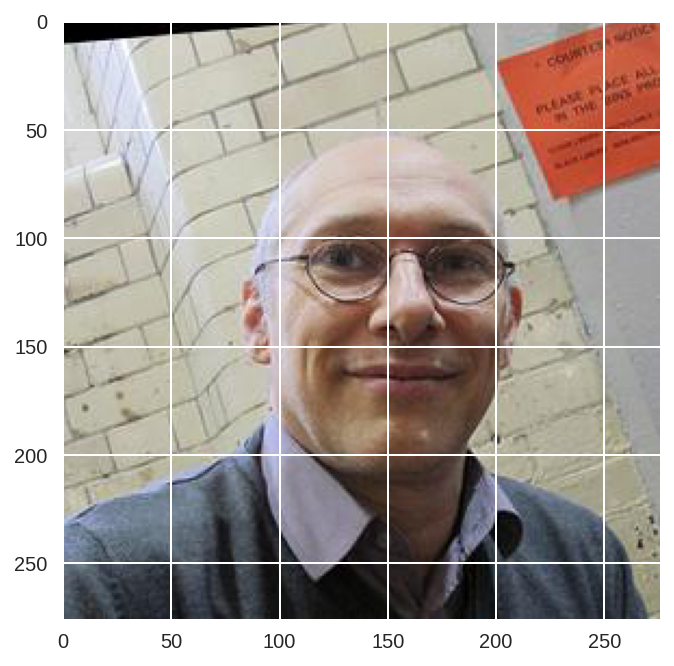


Age: 51


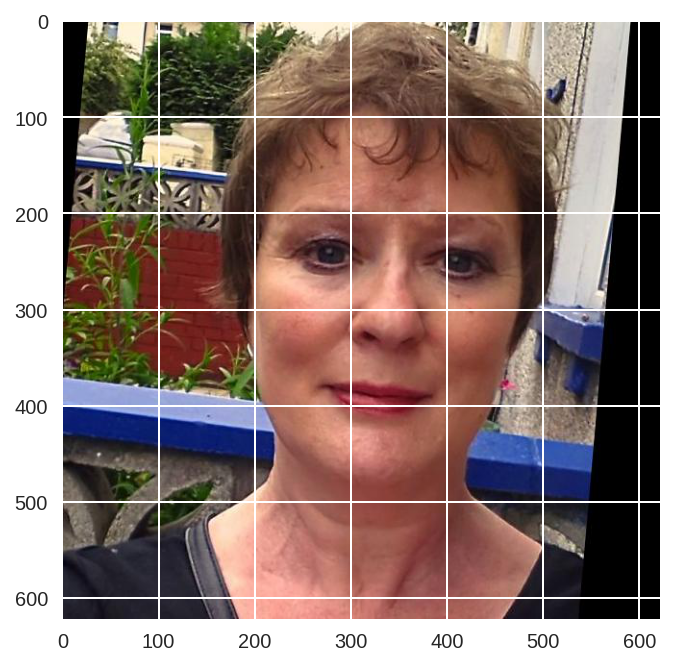

In [8]:
for index, sample_pic in df.sample(5).iterrows():
    print(f'Age: {sample_pic["real_age"]}')
    plt.imshow(np.array(Image.open(filepath+sample_pic['file_name'])))
    plt.show()
    print()

In [9]:
minsize = 200
maxsize = 200
for index, sample_pic in df.sample(500).iterrows():
    shape = np.array(Image.open(filepath+sample_pic['file_name'])).shape
    if shape[0] < minsize:
        minsize = shape[0]
    if shape[0] > maxsize:
        maxsize = shape[0]

print(f'On a random sample of 500 images minimum dimensions are {minsize}x{minsize}, maximum — {maxsize}x{maxsize}')

On a random sample of 500 images minimum dimensions are 55x55, maximum — 2875x2875


### Findings

Here we have a small dataset of images labelled with the person's age. There are no missing values or duplicates in this daset.  
Our target (age) isn't evenly distributed: the median is 29, and IQR is 21. Thus we have a very long tail ranging from 41 to 100. Also, we can see peaks in specific numbers: 25, 30, 35, etc. All this could lead to not the best performance of the model; it would make more significant mistakes in guessing the age above 41.  
Taking a random sample of images, we see that their dimensions differ significantly. So, to avoid losing too much information by reducing everything to the smallest, let's go with the default `target_size` of 256.

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [10]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [11]:
def data_gen():
    try:
        return df, datagen
    except NameError:
        df = pd.read_csv('/datasets/faces/labels.csv', sep=',')
        datagen = ImageDataGenerator(rescale=1/255, validation_split=0.1)
        return df, datagen

In [12]:
def load_train(path):
    df, datagen = data_gen()
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=df, directory=path+'final_files/', 
                                                     x_col='file_name', y_col='real_age', 
                                                     class_mode='raw', target_size=(256, 256), 
                                                     batch_size=32, seed=42, subset='training')
    return train_datagen_flow

In [13]:
def load_test(path):
    df, datagen = data_gen()
    test_datagen_flow = datagen.flow_from_dataframe(dataframe=df, directory=path+'final_files/', 
                                                     x_col='file_name', y_col='real_age', 
                                                     class_mode='raw', target_size=(256, 256), 
                                                     batch_size=32, seed=42, subset='validation')
    return test_datagen_flow

In [14]:
def create_model(input_shape =(256, 256, 3)):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))    
    
    model.compile(loss='mean_squared_error', 
                  optimizer=Adam(learning_rate=0.0001), 
                  metrics=['mean_absolute_error'])     
    return model

In [15]:
def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [16]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [data_gen, load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

```
214/214 - 62s - loss: 223.5033 - mean_absolute_error: 10.6076 - val_loss: 813.9102 - val_mean_absolute_error: 23.7270
Epoch 2/8
214/214 - 39s - loss: 60.3292 - mean_absolute_error: 5.9357 - val_loss: 454.1497 - val_mean_absolute_error: 16.4772
Epoch 3/8
214/214 - 39s - loss: 30.0150 - mean_absolute_error: 4.2479 - val_loss: 139.2508 - val_mean_absolute_error: 9.5518
Epoch 4/8
214/214 - 39s - loss: 18.1234 - mean_absolute_error: 3.3005 - val_loss: 94.0839 - val_mean_absolute_error: 7.5755
Epoch 5/8
214/214 - 39s - loss: 14.3386 - mean_absolute_error: 2.8898 - val_loss: 65.5428 - val_mean_absolute_error: 6.1153
Epoch 6/8
214/214 - 39s - loss: 12.0275 - mean_absolute_error: 2.6519 - val_loss: 65.0573 - val_mean_absolute_error: 6.0597
Epoch 7/8
214/214 - 39s - loss: 9.8570 - mean_absolute_error: 2.4081 - val_loss: 64.8817 - val_mean_absolute_error: 6.0282
Epoch 8/8
214/214 - 39s - loss: 8.6000 - mean_absolute_error: 2.2317 - val_loss: 62.8803 - val_mean_absolute_error: 5.9438

24/24 - 4s - loss: 62.8803 - mean_absolute_error: 5.9438
```
Test MAE: 5.9438

## Conclusions

In this project, we explored whether Data Science can help our supermarket chain detect underage people buying alcohol.  
Using computer vision methods, we built a model to detect a person's age from the camera in the checkout area. Our model's mean absolute error is about 6, which is a pretty good result, but not for this particular task. With such an error, there would be many times when we won't detect an underage person correctly.    
Maybe we better try a different approach. For example, we could ask the person buying an alcoholic drink to show their ID to the camera. Reading the birth date from it would give a significantly accurate result.